This notebook reads in unwrapped igrams from tip of Laguna Salada and plots time series with them

This notebook: <br>
1. Reads in unwrapped igrams (210 of them), stores them in 3D array. Each slice is a single igram, first dimension is dates/time 
2. Does one of the following: (1) removes average phase from upper left 100x100 pixels (2) removes the average phase of the entire image, or (3) removes phase from a single reference point  
3. Plots a single igram to test. Can plot points of reference + interest too (or region of reference if used option (1) above)
4. Extract time series at either 1 or 2 points (depending on reference method used above) 
5. Calculates time series in cm and plots that too.
6. Calculates secular/average velocity of the time series at each point and plots as a map. *This is still very noisy/messy*


This notebook was written on 10-25-22
updated 12-01-22

***

Things to do::

1. Make the time series relative to a point in open desert that is close enough to not have atm. differences than in LS and less chance of unwrapping errors: does that look the same as the time series I did with top left subtracted and then the 2 points differenced? <br>
__DONE__
2. Make time series for groups of pixels rather than just an average over a small area. Do they all look the same as the one I had gotten before? <br>
__DONE__
3. Look at the igrams in the first 1-2 years of time series, is the super fast uplift really occuring? Could be salt growth.<br>
__DONE, I think. Defo seems legit__

4. Make sure I know if positive is uplift or subsidence<br>
__negative is ground moving up__
5. Keep time series of disp. in radians and add lines of 2pi intervals to check for unwrapping errors.

X. Later: unwrap region around Cerro Prieto <br>
X. Later: unwrap region around the TPC anomaly area, what's going on there? 



In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib  widget

Define directory where igrams are sitting. Define directory where we can pull out the dates to loop through. Define size of files to be read in.

In [2]:
# igramsDir is where the cropped, unwrapped igrams are 
igramsDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'

dx = 3000
dy = 750

Load in the dates to loop through and print out the number of interferograms we have.

In [3]:
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vv/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
print(str(numIgrams)+' igrams.')

210 igrams.


Load in the igrams into a 3D array. 

In [4]:
# make an array to hold igrams
igrams = np.ndarray((numIgrams,dy,dx),dtype='float')
for i in range(numIgrams):
    # define the 2 dates. 
    date1=dates[i]; date2=dates[i+1]
    # Read in the igram 
    ds = gdal.Open(igramsDir+date1+"_"+date2+"_filt_unwr.int", gdal.GA_ReadOnly)
    #ds = gdal.Open(igramsDir+date1+"_"+date2+"_unwr.int", gdal.GA_ReadOnly)
    igrams[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
print('igrams loaded.')

igrams loaded.


1. Remove an average of the upper left 

In [12]:
# Pull out the top left ? x ? pixels and remove the average value for each igram 

# initialize an array for corrected igrams 
igramsCor = np.ndarray(np.shape(igrams),dtype='float')

avgY = 30
avgX = 100

for i in range(numIgrams):
    #igramsCor[i] = igrams[i]-np.mean(igrams[i,0:10,-10::])
    
    # try using 200x400 reference region 
    igramsCor[i] = igrams[i]-np.mean(igrams[i,0:avgY,-avgX::])
print('igrams corrected with average over upper left '+str(avgX)+'x'+str(avgY)+' pixels removed.')

igrams corrected with average over upper left 100x30 pixels removed.


2. OR instead of above cell, remove the average over the whole region. See if that makes a cleaner time series

In [ ]:
# remove the average over the whole region
# initialize an array for corrected igrams 
igramsCor = np.ndarray(np.shape(igrams),dtype='float')

for i in range(numIgrams):
    #igramsCor[i] = igrams[i]-np.mean(igrams[i,0:10,-10::])
    
    # remove average over entire image 
    igramsCor[i] = igrams[i]-np.mean(igrams[i,:,:])
print('igrams corrected by subtracting out average over whole image.')

3. BEST OPTION: remove the value at a reference point for each igram. Then, only need to calculate single time series in LS that is relative to this point.

In [19]:
refpoint = [500,2500] # ref point as open desert 
#refpoint = [0,2999] # ref point as upper left corner pixel 
comparepoint = [500,1000]
comparepoint_desert = [500,2500]

In [21]:
# remove the point that I want to use as reference instead 

# initialize an array for corrected igrams 
igramsCor = np.ndarray(np.shape(igrams),dtype='float')

for i in range(numIgrams):
    # remove the value at point (500,2500) which is in open desert
    igramsCor[i] = igrams[i]-igrams[i,refpoint[0],refpoint[1]]
    # can use a different point (?,?) as reference
print('igrams corrected by subtracting value at a reference point.')

igrams corrected by subtracting value at a reference point.


Plot a single igram that we've now loaded in. 

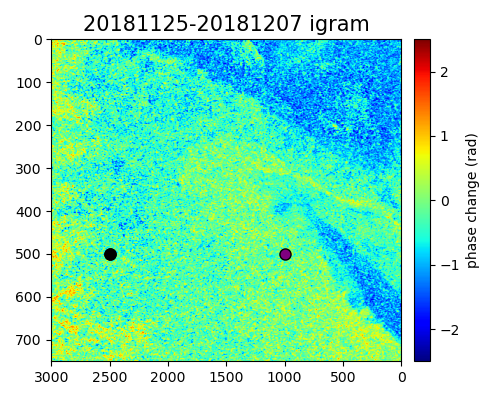

In [22]:
i = 46; date1=dates[i]; date2=dates[i+1]
plt.figure(figsize=(5,4),tight_layout=True) # for poster: figsize=(72/12+1,65/12)
ax = plt.axes()
im = plt.imshow(igramsCor[i],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=-2.5,vmax=2.5)
plt.colorbar(orientation='vertical',pad=0.03,label='phase change (rad)'); plt.set_cmap('jet')
ax.ylabel_style = {'size': 15, 'color': 'black'}; ax.xlabel_style = {'size': 15, 'color': 'black'}
ax.set_xlim([dx,0]); ax.set_ylim([dy,0])
plt.title(str(date1)+'-'+str(date2)+' igram',fontsize=15)
#plt.xlabel('range'); plt.ylabel('azimuth')

# plot a box over the area I'll be averaging to remove 
#avgAreaY = [0,0,avgY,avgY,0]
#avgAreaX = [dx,dx-avgX,dx-avgX,dx,dx]; 
#plt.plot(avgAreaX,avgAreaY,'k-')
plt.plot(comparepoint[1],comparepoint[0],'o',color='purple',markersize=8,mec='k')
plt.plot(comparepoint_desert[1],comparepoint_desert[0],'o',color='darkorange',markersize=8,mec='k')
plt.plot(refpoint[1],refpoint[0],'o',color='k',markersize=8,mec='k')
#plt.xticks([]); plt.yticks([])
plt.show()
#saveAs = 'igram_'+str(date1)+'_'+str(date2)+'.png'
#plt.savefig(saveAs, transparent=True)

Calculate the time of each igram (time btw sequential SLCs) in number of days. Pull out dates as datetime objects, then calculate the difference between each sequential slc, then convert the timedelta objects to number of days. 

In [8]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# take numIgrams and pull out the igram_dates, corresponding to the first day of each igram
igram_dates = slc_dates[0:-1]
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt = np.zeros([len(dt1),1])
for i in range(len(dt)):
    dt[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
print('slc_dates: '+str(np.shape(slc_dates)))
print('igram_dates: '+str(np.shape(igram_dates)))
print('^datetime objects now')
#print(dt)

slc_dates: (211,)
igram_dates: (210,)
^datetime objects now


1. Extract time series at two points: in LS and open desert. Plot the time series in radians/igram period to start off. (Convert later)

In [ ]:
# initialize arrays to hold time series for each point
disp_rate_LS = np.ndarray((numIgrams,),dtype='float')
disp_rate_desert = np.ndarray((numIgrams,),dtype='float')
# loop through and average over small area (10 pixels on each side)
window = 20
for i in range(numIgrams): # these are rates in (radians/igram interval)
    disp_rate_LS[i] = np.mean(igramsCor[i,comparepoint[0]-window:comparepoint[0]+window,comparepoint[1]-window:comparepoint[1]+window]) 
    disp_rate_desert[i] = np.mean(igramsCor[i,comparepoint_desert[0]-window:comparepoint_desert[0]+window,comparepoint_desert[1]-window:comparepoint_desert[1]+window])
# calculate cumulative displacement in radians 
cum_disp_LS = np.cumsum(disp_rate_LS) # this and next are cumulative disp in (rad)
cum_disp_desert = np.cumsum(disp_rate_desert)

2. Extract a time series at a point in LS relative to a single reference point. Plot the time series in radians/igram to start.

In [23]:
# initialize arrays to hold time series for each point
disp_rate_LS = np.ndarray((numIgrams,),dtype='float')
disp_rate_desert = np.ndarray((numIgrams,),dtype='float')
for i in range(numIgrams): # these are rates in (radians/igram interval)
    disp_rate_LS[i] = igramsCor[i,comparepoint[0],comparepoint[1]]
    disp_rate_desert[i] = igramsCor[i,comparepoint_desert[0],comparepoint_desert[1]]
# calculate cumulative displacement in radians 
cum_disp_LS = np.cumsum(disp_rate_LS) # this and next are cumulative disp in (rad)
cum_disp_desert = np.cumsum(disp_rate_desert) 

Load in precip data and gather the dates of the storms that had >some threshold value of precipitation. Put those dates into a list for plotting later.

In [10]:
# Read in 2day precipitation data
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')
#precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_cumulative.txt', dtype='float')

# BIGGER STORMS
# days with precip > 0.3cm 
print('i \tdate \t\t       precip > 0.3cm')
#print('i \tdate \t\t       precip > 0.0cm')
rain_dates = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.3:
        print(str(i)+'\t'+str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])

i 	date 		       precip > 0.3cm
0	2017-05-10 00:00:00    0.33020000000000005 cm
47	2018-12-07 00:00:00    5.0546 cm
74	2019-09-27 00:00:00    1.4478 cm
83	2019-11-20 00:00:00    2.286 cm
97	2020-02-12 00:00:00    1.1684 cm
102	2020-03-13 00:00:00    0.40640000000000004 cm
107	2020-04-12 00:00:00    0.9906 cm
186	2021-08-11 00:00:00    0.381 cm


Plot the time series at LS and in open desert (in radians)

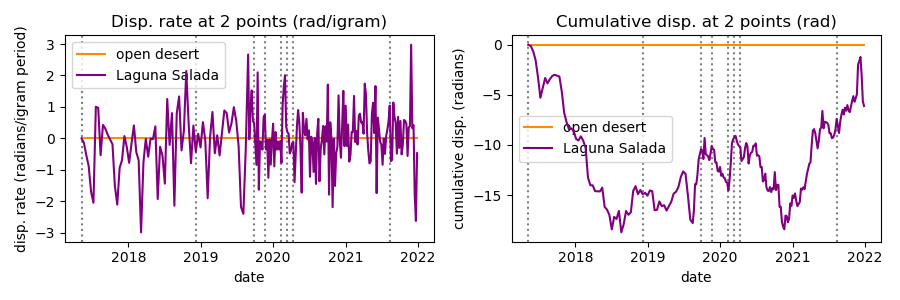

In [24]:
plt.figure(figsize=(9,3),tight_layout='TRUE')
plt.subplot(1,2,1)
plt.plot(igram_dates,disp_rate_desert,'darkorange',label='open desert',zorder=3)
plt.plot(igram_dates,disp_rate_LS,'purple',label='Laguna Salada',zorder=10)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.legend(); plt.title('Disp. rate at 2 points (rad/igram)')
plt.ylabel('disp. rate (radians/igram period)'); plt.xlabel('date')
plt.subplot(1,2,2)
plt.plot(igram_dates,cum_disp_desert,'darkorange',label='open desert',zorder=3)
plt.plot(igram_dates,cum_disp_LS,'purple',label='Laguna Salada',zorder=10)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.legend(); plt.title('Cumulative disp. at 2 points (rad)')
plt.ylabel('cumulative disp. (radians)'); plt.xlabel('date')
plt.show()

Convert radians/igram period to cm/yr rates using radians --> cm and igram --> dt

In [ ]:
# make a conversion factor from radians to cm 
wavelength = 5.5465763
rad2cm = wavelength/(4*np.pi) # this is conversion factor that I multiply by the data (which is in rads)

disp_rate_LS_cmYr = disp_rate_LS*rad2cm/dt.reshape((numIgrams,)) # this and next are rates in (cm/yr)
disp_rate_desert_cmYr = disp_rate_desert*rad2cm/dt.reshape((numIgrams,))

cum_disp_LS_cm = np.cumsum(disp_rate_LS*rad2cm) # this and next are cumulative disp in (cm)
cum_disp_desert_cm = np.cumsum(disp_rate_desert*rad2cm)

Plot the converted time series (in cm now)

In [ ]:
plt.figure(figsize=(9,3),tight_layout='TRUE')
plt.subplot(1,2,1)
#plt.plot(igram_dates,disp_rate_desert_cmYr,'darkorange',label='open desert',zorder=3)
plt.plot(igram_dates,disp_rate_LS_cmYr,'purple',label='Laguna Salada',zorder=10)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.legend(); plt.title('Disp. rate at 2 points (cm/yr)')
plt.ylabel('disp. rate (cm/yr)'); plt.xlabel('date')
plt.subplot(1,2,2)
#plt.plot(igram_dates,cum_disp_desert_cm,'darkorange',label='open desert',zorder=3)
plt.plot(igram_dates,cum_disp_LS_cm,'purple',label='Laguna Salada',zorder=10)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.legend(); plt.title('Cumulative disp. at 2 points (cm)')
plt.ylabel('cumulative disp. (cm)'); plt.xlabel('date')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.5),tight_layout='TRUE')
#plt.plot(igram_dates,cum_disp_desert_cm,'darkorange',label='open desert',zorder=3)
plt.plot(igram_dates,cum_disp_LS_cm,'purple',label='Laguna Salada',zorder=10)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.legend(); #plt.title('Cumulative disp. at 2 points (cm)')
plt.ylabel('cumulative disp. (cm)'); plt.xlabel('date')
plt.show()
#plt.savefig("cum_disp_filt.png", transparent=True)

Make a plot showing the difference between the two (displacement relative to each other)

In [ ]:
plt.figure(figsize=(6,3),tight_layout='TRUE')
plt.plot(igram_dates,cum_disp_LS_cm-cum_disp_desert_cm,'blue',zorder=3)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
plt.title('Disp. between the 2 points (cm)')
plt.ylabel('cumulative disp.(cm/)'); #plt.xlabel('date')
plt.show()

#plt.savefig("disp_btw_pts.png",transparent=True)

Now calculate an average displacement rate for each pixel in my region. Extract time series at one pixel at a time, convert it to cm and do cumulative sum, then fit a line to it (first try entire time series, then try just up through 2019 like Jiang and Lohman, 2021), then put the rate (slope of the best-fit line) into an array and plot the array.

In [ ]:
# initialize arrays to hold time series for each point
disp_rates_temp = np.ndarray((numIgrams,),dtype='float')
cum_disp_temp_cm = np.ndarray((numIgrams,),dtype='float')
avg_disp_rates = np.ndarray((dy,dx),dtype='float') 
# make a conversion factor from radians to cm 
wavelength = 5.5465763
rad2cm = wavelength/(4*np.pi) # this is conversion factor that I multiply by the data (which is in rads)
# need to convert igram_dates to number of days/years to fit a line with them
igram_dates_floatyrs = np.ndarray(np.shape(igram_dates),dtype='float')
for i in range(numIgrams):
    igram_dates_floatyrs[i] = (igram_dates[i]-igram_dates[0]).days/365.25

# loop through pixels 
for y in range(dy):
    for x in range(dx):
        # pull out time series at the pixel 
        disp_rates_temp = igramsCor[:,y,x] 
        # convert it to cm and cumulative sum it 
        cum_disp_temp_cm = np.cumsum(disp_rates_temp*rad2cm)
        # now fit a line to this. m is slope, b is intercept
        m, b = np.polyfit(igram_dates_floatyrs, cum_disp_temp_cm, 1)
        # put that rate into the avg_disp_rates array 
        avg_disp_rates[y,x] = m

Now plot the average rates over the entire area

In [ ]:
plt.figure(figsize=(72/12+1,65/12),tight_layout=True)
ax = plt.axes()
#im = plt.pcolor(igramsCor[i])
im = plt.imshow(avg_disp_rates, aspect='auto', vmin=-8, vmax=8, \
                interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.03,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
ax.set_xlim([dx,0]); ax.set_ylim([dy,0])
#plt.title('Average disp rates from filt igrams',fontsize=15)
#plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

#plt.savefig("disp_rates.png", transparent=True)